# Google Colaboratoryでは実行確認済み (2023/08/24 現在)
* その他の環境では実行できない可能性あり
* テキストマイニングのコード内容は "https://www.takapy.work/entry/2020/05/17/192947" に準拠
* PDFファイルの内容をテキストマイニングできるようにした

In [102]:
# MeCabとnlplotライブラリのインストール
!pip install mecab-python3 unidic-lite
!pip install nlplot
!pip install tika # pdf読み込み用
!pip install mojimoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mojimoji: filename=mojimoji-0.0.12-cp310-cp310-linux_x86_64.whl size=171696 sha256=2bbbc9c29aac7e31065b1b413681d94ef01fa6839eaefeeb65f8aaa6f2090f1d
  Stored in directory: /root/.cache/pip/wheels/96/25/c5/225e7892b9b77f1b0b41b2fea7aaa34572e3f6012114e13100
Successfully built mojimoji


# データの準備

In [183]:
# ライブラリのインポート
import nlplot
import pandas as pd
import plotly
import MeCab
import re
import mojimoji
from plotly.subplots import make_subplots
from plotly.offline import iplot
from tika import parser
import matplotlib.pyplot as plt
%matplotlib inline

# 1. データ
### データの読み込み (PDFファイル)
pdf_path = "13_692.pdf" # 任意のPDFファイルのパスを指定する
pdf_read = parser.from_file(pdf_path)
text = pdf_read["content"]

### --- 数字, 記号の削除 ---
### 数字の削除
num_regex = re.compile('\d+,?\d*')
### 数字は全て0に置換する
text = num_regex.sub('', text)
# 記号の削除
code_regex = re.compile('[\t\s!"#$%&\'\\\\()*+,-./:;；：<=>?@[\\]^_`{|}~○｢｣「」〔〕“”〈〉'\
    '『』【】＆＊（）＄＃＠？！｀＋￥¥％♪…◇→←↓↑｡･ω･｡ﾟ´∀｀ΣДｘ⑥◎©︎♡★☆▽※ゞノ〆εσ＞＜┌┘]')
text = code_regex.sub('', text)
### 全角 --> 半角 の変換
# 全角から半角に変換（カナは除く）
text = mojimoji.zen_to_han(text, kana=False)
# 半角カナから全角カナに変換
text = mojimoji.han_to_zen(text, ascii=False)
# 全ての文字を小文字に変換
text = text.lower()
### アルファベットの削除
alphabet = 'abcdefghijklmnopqrstuvwxyz'
alpha_list = [alpha for alpha in alphabet]
# alph = re.compile('abcdefghijklmnopqrstuvwxyz')
# text = code_regex.sub('', text)
### --- ここまで ---

### データの加工
list_data = text.split('\n') # str  --> list 変換
df = pd.DataFrame(list_data) # list --> df   変換
df.columns = ['text']        # dfのカラム名変更

# 2. 形態素解析の実行
### 形態素解析の処理
def mecab_text(text):
    ### MeCabのインスタンス作成
    mecab = MeCab.Tagger()
    ### 形態素解析
    node = mecab.parseToNode(text)
    ### 形態素解析した結果の格納リスト
    wordlist = []
    while node:
        ### 名詞のみリストに格納
        if node.feature.split(',')[0] == '名詞':
            wordlist.append(node.surface)
        node = node.next
    return wordlist
### 形態素結果のリスト化と、データフレームdfへの列追加
df['words'] = df['text'].apply(mecab_text)

## df['words']内のアルファベットを削除
list2 = df['words'].values.tolist()
def remove_alphabet(words):
    return [word for word in words if not re.match(r'^[a-zA-Z]+$', word)]
result = remove_alphabet(list2[0])
result_list = [result]
df['words_new'] = result_list

## 不要なカラム削除
df = df.drop(columns='words')
### カラム名変更
df = df.rename({'words_new': 'words'}, axis='columns')

### dfの先頭5行を表示(確認のため)
print(df.head())

                                                text  \
0  [解説]対話型進化計算法の研究動向perspectiveoninteractiveevolu...   

                                               words  
0  [解説, 対話, 進化, 計算, 法, 研究, 動向, 高木, 英行, 畝, 達夫, 寺野,...  


# 可視化
## 3-1. N-gram bar chartの実行

In [184]:
# 3. 可視化の実行
## 3-1. N-gram bar chartの実行
npt = nlplot.NLPlot(df, target_col='words')

### top_nで頻出上位単語, min_freqで頻出下位単語を指定
stopwords = npt.get_stopword(top_n=0, min_freq=4) # n(>4)回以上出現した単語のみ

npt.bar_ngram(
    title='uni-gram',
    xaxis_label='word_count',
    yaxis_label='word',
    ngram=1,
    top_n=50,
    stopwords=stopwords,
)

100%|██████████| 1/1 [00:00<00:00, 14.89it/s]


## 3-2. wordcloudの実行

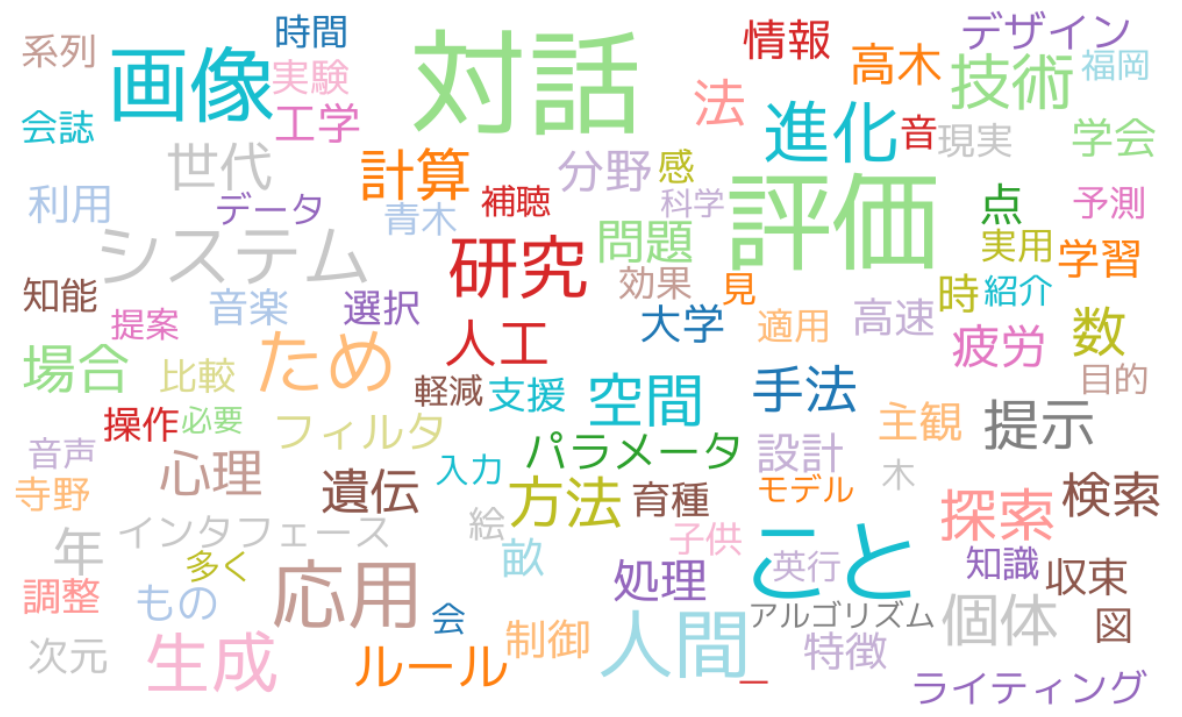

In [185]:
## 3-2. wordcloudの実行
fig_wc = npt.wordcloud(
    width=1000,
    height=600,
    max_words=100,
    max_font_size=100,
    colormap='tab20_r',
    stopwords=stopwords,
    mask_file=None,
    save=False
)
plt.figure(figsize=(15, 25))
plt.imshow(fig_wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## 3-3. N-gram tree Mapの実行

In [186]:
## 3-3. N-gram tree Mapの実行
fig_treemap = npt.treemap(
    title='Tree map',
    ngram=1,
    top_n=50,
    width=1300,
    height=600,
    stopwords=stopwords,
    verbose=False,
    save=False
)
fig_treemap.show()

## 3-4. Histogram of the word countの実行

In [187]:
## 3-4. Histogram of the word countの実行
### 単語数の分布
fig_histgram = npt.word_distribution(
    title='word distribution',
    xaxis_label='count',
    yaxis_label='',
    width=1000,
    height=500,
    color=None,
    template='plotly',
    bins=None,
    save=False,
)
fig_histgram.show()

* co-occurrence networksは実行の際, エラーが発生
* co-occurrence networksが実行できないため, sunburst chartも実行不可


In [103]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'
alpha_list = [alpha for alpha in alphabet]

In [106]:
print(alpha_list)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
